In [1]:
# Running RandomForest regressions to discover a lifters best lift
# across the 3 lifts.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits

In [2]:
# Sampling 20,000 data entries
n = 767672 
s = 20000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Chris Lepp,M,SBD,Wraps,26.0,24-34,M-OR,82.50,82.5,250.0,...,700.0,1,468.93,468.93,452.71,712.95,NaN,Australia,GPC-AUS,2018-10-27
1,Carla Rizk,F,SBD,Wraps,21.0,20-23,F-OR,88.10,90,165.0,...,455.0,1,396.75,404.69,345.54,680.83,NaN,NaN,GPC-AUS,2015-05-19
2,Jodie Elisara,F,SBD,Wraps,33.0,24-34,F-OR,142.70,90+,0.0,...,245.0,12,189.87,189.87,159.80,324.99,NaN,Australia,GPC-AUS,2015-05-19
3,Adrian Ng,M,SBD,Wraps,34.0,24-34,M-OR,88.40,90,175.0,...,532.5,15,343.12,343.12,330.78,497.71,NaN,NaN,GPC-AUS,2015-05-19
4,Andy Hargreaves,M,SBD,Wraps,27.0,24-34,M-OR,148.30,140+,0.0,...,785.0,5,435.03,435.03,411.19,575.38,NaN,Australia,GPC-AUS,2015-05-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,David Crater,M,B,Raw,46.0,45-49,M-OB-R-U,109.95,110,0.0,...,195.0,1,114.77,122.58,109.69,661.79,NaN,USA,365Strong,2019-11-10
19996,Michaela Coffin,F,BD,Raw,31.5,24-34,wsm1,98.34,90+,0.0,...,195.0,1,163.18,163.18,140.47,NaN,Yes,USA,NASA,2019-04-27
19997,Dakota Baker,M,BD,Raw,23.0,20-23,nov,137.89,140,0.0,...,420.0,1,235.24,235.24,223.84,NaN,Yes,USA,NASA,2019-07-20
19998,Robert McKinzie,M,D,Raw,58.5,55-59,dlm2,119.25,125,0.0,...,227.5,1,130.99,169.10,125.51,445.80,Yes,USA,NASA,2020-02-22


In [3]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              1173
dtype: int64

In [4]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)

In [6]:
data

,Sex,Event,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,M,SBD,Wraps,26.0,82.50,272.50,160.00,267.50,468.93
1,F,SBD,Wraps,21.0,88.10,165.00,100.00,190.00,396.75
2,F,SBD,Wraps,33.0,142.70,115.00,70.00,60.00,189.87
3,M,SBD,Wraps,34.0,88.40,187.50,120.00,225.00,343.12
4,M,SBD,Wraps,27.0,148.30,320.00,180.00,285.00,435.03
...,...,...,...,...,...,...,...,...,...
19984,M,SBD,Single-ply,19.0,125.65,204.12,142.88,195.04,308.56
19985,M,SBD,Single-ply,18.5,65.86,115.67,90.72,127.01,262.23
19989,M,SBD,Wraps,27.0,87.09,182.50,155.00,237.50,373.47
19992,M,SBD,Wraps,21.0,106.82,230.00,137.50,207.50,341.58


In [7]:
# Remove the last couple of columns
data = data.drop(columns = ['Event'])

In [8]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,1,1,26.0,82.50,272.50,160.00,267.50,468.93
1,0,1,21.0,88.10,165.00,100.00,190.00,396.75
2,0,1,33.0,142.70,115.00,70.00,60.00,189.87
3,1,1,34.0,88.40,187.50,120.00,225.00,343.12
4,1,1,27.0,148.30,320.00,180.00,285.00,435.03
...,...,...,...,...,...,...,...,...
19984,1,3,19.0,125.65,204.12,142.88,195.04,308.56
19985,1,3,18.5,65.86,115.67,90.72,127.01,262.23
19989,1,1,27.0,87.09,182.50,155.00,237.50,373.47
19992,1,1,21.0,106.82,230.00,137.50,207.50,341.58


In [9]:
# Normalise the data, scaling to values between 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [10]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_squat = data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg']]

target_squat = data[['Best3SquatKg']]

test_bench = data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3SquatKg', 'Best3DeadliftKg']]

target_bench = data[['Best3BenchKg']]

test_dead = data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3SquatKg']]

target_dead = data[['Best3DeadliftKg']]

In [11]:
# Preparing sets
S = test_squat
s = target_squat
B = test_bench
b = target_bench
D = test_dead
d = target_dead

In [12]:
# Split sets into training and test sets
from sklearn.model_selection import train_test_split
S_train, S_test, s_train, s_test = train_test_split(S, s, test_size=0.1, random_state=3)
B_train, B_test, b_train, b_test = train_test_split(B, b, test_size=0.1, random_state=3)
D_train, D_test, d_train, d_test = train_test_split(D, d, test_size=0.1, random_state=3)

In [13]:
# Prepare model, then fit the models and check scores!
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth = 30)

In [38]:
model.fit(S_train, s_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [39]:
model.score(S_test, s_test)

0.9692854049928338

In [16]:
model.fit(B_train, b_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
model.score(B_test, b_test)

0.9510490705446452

In [18]:
model.fit(D_train, d_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
model.score(D_test, d_test)

0.961541596782276

In [95]:
s_pred = pd.DataFrame(model.predict(S_test))
S_bw = pd.DataFrame(S_test['BodyweightKg'])
S_bw = S_bw.reset_index()
s_pred = s_pred.reset_index()
S_bw = S_bw.drop(columns = 'index')
s_pred = s_pred.drop(columns = 'index')
s_t = s_test.reset_index()
s_t = s_t.drop(columns = 'index')

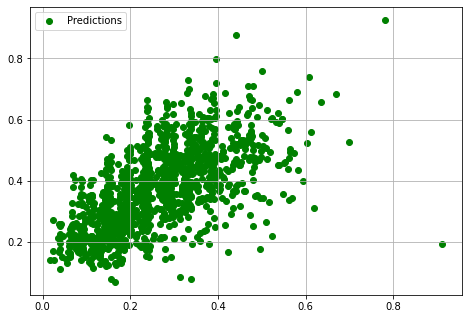

In [117]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_pred, color = 'g', label='Predictions')
ax.legend()
ax.grid(True)
plt.show()

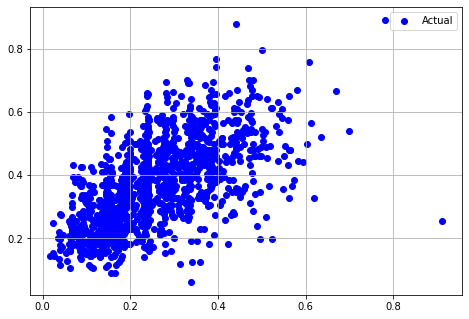

In [98]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'b', label='Actual')
ax.legend()
ax.grid(True)
plt.show()

<Figure size 432x288 with 0 Axes>

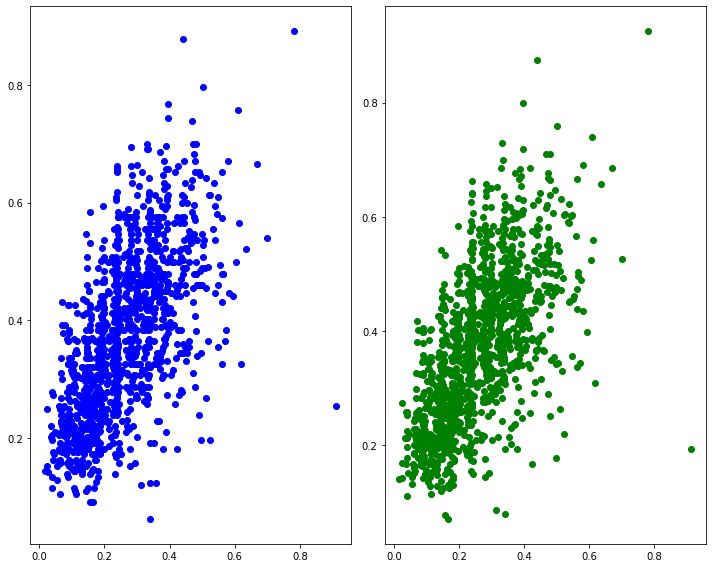

In [120]:
fig = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
ax[0].scatter(S_bw, s_test, color = 'b', label='Actual')
ax[1].scatter(S_bw, s_pred, color = 'g', label='Pred Squat')
fig.tight_layout()
plt.show()